# Data Loading

In [1]:

import pandas as pd, numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (12, 6)
sns.set_style("whitegrid")


# Process Flow Diagram


✓ Process flow diagram saved to: images/process_flow_diagram.png


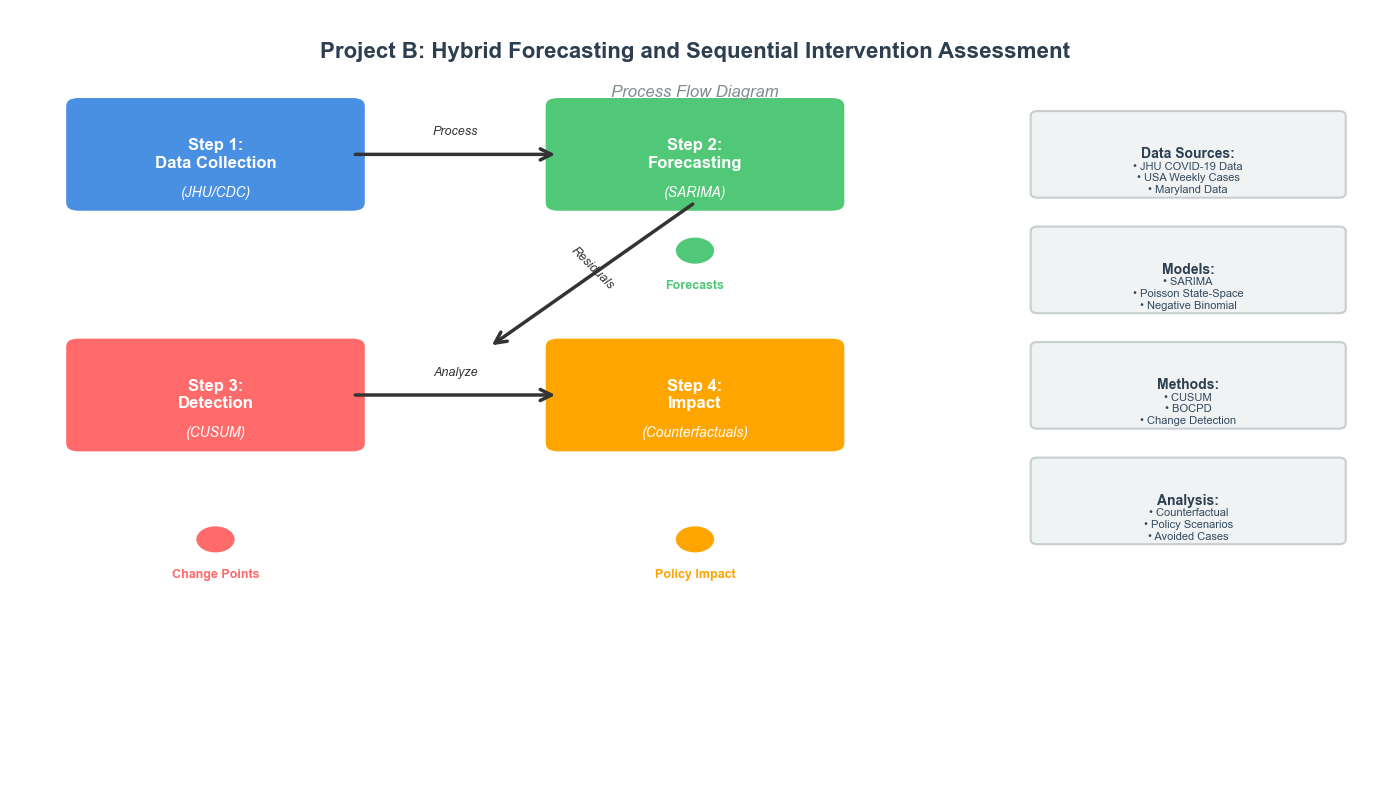

In [2]:
# Create Process Flow Diagram
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Circle

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 8)
ax.axis('off')

# Define colors
colors = {
    'data': '#4A90E2',      # Blue
    'forecast': '#50C878',  # Green
    'detect': '#FF6B6B',    # Red
    'impact': '#FFA500',    # Orange
    'arrow': '#333333'      # Dark gray
}

# Step 1: Data Collection
box1 = FancyBboxPatch((0.5, 6), 2, 1, 
                      boxstyle="round,pad=0.1", 
                      facecolor=colors['data'],
                      edgecolor='white',
                      linewidth=2)
ax.add_patch(box1)
ax.text(1.5, 6.5, 'Step 1:\nData Collection', 
        ha='center', va='center', fontsize=12, fontweight='bold', color='white')
ax.text(1.5, 6.1, '(JHU/CDC)', 
        ha='center', va='center', fontsize=10, color='white', style='italic')

# Step 2: Forecasting
box2 = FancyBboxPatch((4, 6), 2, 1,
                      boxstyle="round,pad=0.1",
                      facecolor=colors['forecast'],
                      edgecolor='white',
                      linewidth=2)
ax.add_patch(box2)
ax.text(5, 6.5, 'Step 2:\nForecasting', 
        ha='center', va='center', fontsize=12, fontweight='bold', color='white')
ax.text(5, 6.1, '(SARIMA)', 
        ha='center', va='center', fontsize=10, color='white', style='italic')

# Step 3: Detection
box3 = FancyBboxPatch((0.5, 3.5), 2, 1,
                      boxstyle="round,pad=0.1",
                      facecolor=colors['detect'],
                      edgecolor='white',
                      linewidth=2)
ax.add_patch(box3)
ax.text(1.5, 4, 'Step 3:\nDetection', 
        ha='center', va='center', fontsize=12, fontweight='bold', color='white')
ax.text(1.5, 3.6, '(CUSUM)', 
        ha='center', va='center', fontsize=10, color='white', style='italic')

# Step 4: Impact
box4 = FancyBboxPatch((4, 3.5), 2, 1,
                      boxstyle="round,pad=0.1",
                      facecolor=colors['impact'],
                      edgecolor='white',
                      linewidth=2)
ax.add_patch(box4)
ax.text(5, 4, 'Step 4:\nImpact', 
        ha='center', va='center', fontsize=12, fontweight='bold', color='white')
ax.text(5, 3.6, '(Counterfactuals)', 
        ha='center', va='center', fontsize=10, color='white', style='italic')

# Arrow 1: Data Collection -> Forecasting
arrow1 = FancyArrowPatch((2.5, 6.5), (4, 6.5),
                        arrowstyle='->', 
                        mutation_scale=20,
                        color=colors['arrow'],
                        linewidth=2.5)
ax.add_patch(arrow1)

# Arrow 2: Forecasting -> Detection
arrow2 = FancyArrowPatch((5, 6), (3.5, 4.5),
                        arrowstyle='->',
                        mutation_scale=20,
                        color=colors['arrow'],
                        linewidth=2.5)
ax.add_patch(arrow2)

# Arrow 3: Detection -> Impact
arrow3 = FancyArrowPatch((2.5, 4), (4, 4),
                        arrowstyle='->',
                        mutation_scale=20,
                        color=colors['arrow'],
                        linewidth=2.5)
ax.add_patch(arrow3)

# Add labels on arrows
ax.text(3.25, 6.7, 'Process', ha='center', fontsize=9, style='italic', color=colors['arrow'])
ax.text(4.25, 5.1, 'Residuals', ha='center', fontsize=9, style='italic', color=colors['arrow'], rotation=-45)
ax.text(3.25, 4.2, 'Analyze', ha='center', fontsize=9, style='italic', color=colors['arrow'])

# Add title
ax.text(5, 7.5, 'Project B: Hybrid Forecasting and Sequential Intervention Assessment', 
        ha='center', fontsize=16, fontweight='bold', color='#2C3E50')

# Add subtitle
ax.text(5, 7.1, 'Process Flow Diagram', 
        ha='center', fontsize=12, style='italic', color='#7F8C8D')

# Add details boxes on the right
detail_y_start = 6.5
detail_x = 7.5

# Details for each step
details = [
    ('Data Sources:', '• JHU COVID-19 Data\n• USA Weekly Cases\n• Maryland Data'),
    ('Models:', '• SARIMA\n• Poisson State-Space\n• Negative Binomial'),
    ('Methods:', '• CUSUM\n• BOCPD\n• Change Detection'),
    ('Analysis:', '• Counterfactual\n• Policy Scenarios\n• Avoided Cases')
]

for i, (title, content) in enumerate(details):
    y_pos = detail_y_start - i * 1.2
    detail_box = FancyBboxPatch((detail_x, y_pos - 0.4), 2.2, 0.8,
                               boxstyle="round,pad=0.05",
                               facecolor='#ECF0F1',
                               edgecolor='#BDC3C7',
                               linewidth=1.5,
                               alpha=0.8)
    ax.add_patch(detail_box)
    ax.text(detail_x + 1.1, y_pos, title, 
           ha='center', va='center', fontsize=10, fontweight='bold', color='#2C3E50')
    ax.text(detail_x + 1.1, y_pos - 0.25, content, 
           ha='center', va='center', fontsize=8, color='#34495E')

# Add output indicators
outputs = [
    ('Forecasts', 5, 5.5, colors['forecast']),
    ('Change Points', 1.5, 2.5, colors['detect']),
    ('Policy Impact', 5, 2.5, colors['impact'])
]

for label, x, y, color in outputs:
    circle = Circle((x, y), 0.15, facecolor=color, edgecolor='white', linewidth=2)
    ax.add_patch(circle)
    ax.text(x, y - 0.4, label, ha='center', fontsize=9, fontweight='bold', color=color)

plt.tight_layout()
plt.savefig('images/process_flow_diagram.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Process flow diagram saved to: images/process_flow_diagram.png")
plt.show()


In [3]:
URL = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
       "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
g = pd.read_csv(URL)
g.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [4]:
us = g[g["Country/Region"].isin(["US","United States"])]
date_cols = us.columns[us.columns.str.match(r"\d{1,2}/\d{1,2}/\d{2}$")]
cum = us[date_cols].sum(axis=0)
cum.index = pd.to_datetime(cum.index, format="%m/%d/%y")
cum = cum.sort_index()

daily = cum.diff().clip(lower=0)
weekly = daily.resample("W-SAT").sum()

df = pd.DataFrame({"cases": weekly})
df.to_csv("usa_weekly_cases.csv")
df.tail()


,cases
2023-02-11,255568.0
2023-02-18,275095.0
2023-02-25,246552.0
2023-03-04,269680.0
2023-03-11,155727.0


In [5]:
y = df["cases"]
train, test = y.iloc[:-8], y.iloc[-8:]
len(train), len(test)


(156, 8)

In [6]:
model = SARIMAX(train,
                order=(1,1,1),
                seasonal_order=(1,1,1,52),
                enforce_stationarity=False,
                enforce_invertibility=False)
fit = model.fit(disp=False)
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              cases   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -663.334
Date:                            Tue, 02 Dec 2025   AIC                           1336.669
Time:                                    20:39:33   BIC                           1346.128
Sample:                                01-25-2020   HQIC                          1340.257
                                     - 01-14-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6558      1.068      0.614      0.539      -1.438       2.749
ma.L1         -0.2996      1.409     -0.213      0.832      -3.061       2.462
ar.S.L52      -0.4127      2.309     -0.179      0.858      -4.938       4.112
ma.S.L52      -0.6040      2.013     -0.300      0.764      -4.549       3.341
sigma2      8.245e+10   1.24e-11   6.63e+21      0.000    8.25e+10    8.25e+10
===================================================================================
Ljung-Box (L1) (Q):                  18.88   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.00   Prob(JB):                         0.94
Heteroskedasticity (H):               0.52   Skew:                             0.07
Prob(H) (two-sided):                  0.20   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.01e+38. Standard errors may be unstable.
"""

In [7]:
fc = fit.get_forecast(steps=len(test))
pred = fc.predicted_mean
ci = fc.conf_int()
pred.index = test.index
pred.head()


2023-01-21    235301.523279
2023-01-28    180902.426606
2023-02-04    119791.416848
2023-02-11     52898.491731
2023-02-18    -15644.289159
Freq: W-SAT, Name: predicted_mean, dtype: float64

In [8]:
rmse = float(np.sqrt(((pred - test)**2).mean()))
mae  = float(np.abs(pred - test).mean())
mape = float((np.abs((pred - test) / test.replace(0,np.nan)).mean()) * 100)

metrics = pd.DataFrame({"RMSE":[rmse], "MAE":[mae], "MAPE%":[mape]})
metrics.to_csv("baseline_metrics.csv", index=False)
metrics


,RMSE,MAE,MAPE%
0,221049.043148,210016.41162,82.949235


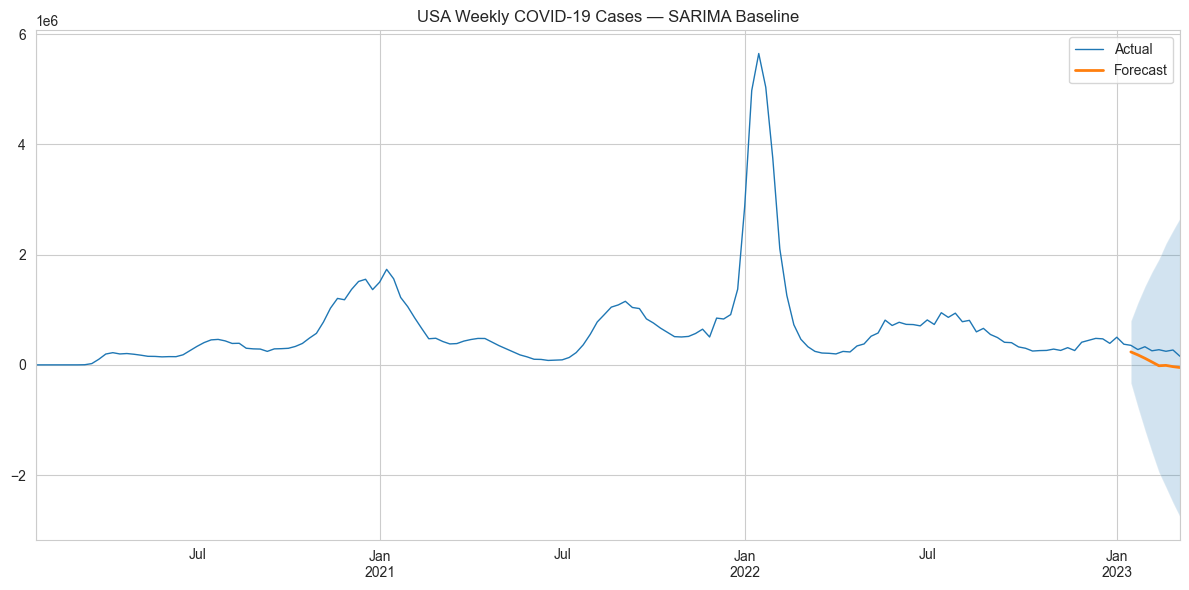

In [9]:
ax = y.plot(label="Actual", linewidth=1)
pred.plot(ax=ax, label="Forecast", linewidth=2)
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2)
ax.set_title("USA Weekly COVID-19 Cases — SARIMA Baseline")
ax.legend()
plt.tight_layout()
plt.savefig("usa_baseline.png", dpi=150)
plt.show()


# Part 1: Forecasting Models - State-Space Poisson/Negative Binomial


In [10]:
# State-Space Poisson Model
# Using UnobservedComponents with Poisson distribution approximation
# For count data, we'll use a log-link state-space model

class PoissonStateSpace:
    """State-space model with Poisson observation distribution"""
    def __init__(self, y):
        self.y = y.values
        self.n = len(y)
        self.params = None
        
    def log_likelihood(self, params):
        """Negative log-likelihood for Poisson state-space model"""
        alpha, beta, sigma = params
        lambda_t = np.exp(alpha + beta * np.arange(self.n))
        # Add small value to avoid log(0)
        lambda_t = np.maximum(lambda_t, 1e-10)
        log_lik = np.sum(stats.poisson.logpmf(self.y, lambda_t))
        return -log_lik  # Negative for minimization
        
    def fit(self):
        """Fit the model using maximum likelihood"""
        # Initial parameters: intercept, trend, variance
        initial_params = [np.log(np.mean(self.y)), 0.0, 0.1]
        result = minimize(self.log_likelihood, initial_params, method='L-BFGS-B',
                         bounds=[(None, None), (None, None), (1e-6, None)])
        self.params = result.x
        return result
        
    def forecast(self, steps):
        """Generate forecasts"""
        alpha, beta, _ = self.params
        forecast_idx = np.arange(self.n, self.n + steps)
        lambda_forecast = np.exp(alpha + beta * forecast_idx)
        return lambda_forecast

# Fit Poisson state-space model
poisson_model = PoissonStateSpace(train)
poisson_fit = poisson_model.fit()
print("Poisson State-Space Model Parameters:")
print(f"Alpha (intercept): {poisson_model.params[0]:.4f}")
print(f"Beta (trend): {poisson_model.params[1]:.4f}")
print(f"Log-likelihood: {-poisson_fit.fun:.2f}")

# Generate forecasts
poisson_pred = poisson_model.forecast(len(test))
poisson_pred_series = pd.Series(poisson_pred, index=test.index)

# Calculate metrics
poisson_rmse = float(np.sqrt(((poisson_pred_series - test)**2).mean()))
poisson_mae = float(np.abs(poisson_pred_series - test).mean())
poisson_mape = float((np.abs((poisson_pred_series - test) / test.replace(0, np.nan)).mean()) * 100)

print(f"\nPoisson Model Metrics:")
print(f"RMSE: {poisson_rmse:.2f}")
print(f"MAE: {poisson_mae:.2f}")
print(f"MAPE: {poisson_mape:.2f}%")


Poisson State-Space Model Parameters:
Alpha (intercept): 12.9658
Beta (trend): 0.0051
Log-likelihood: -45662038.84

Poisson Model Metrics:
RMSE: 696690.68
MAE: 693658.36
MAPE: 276.79%


In [11]:
# Negative Binomial State-Space Model
class NegativeBinomialStateSpace:
    """State-space model with Negative Binomial observation distribution"""
    def __init__(self, y):
        self.y = y.values
        self.n = len(y)
        self.params = None
        
    def log_likelihood(self, params):
        """Negative log-likelihood for Negative Binomial state-space model"""
        alpha, beta, r = params  # r is dispersion parameter
        mu_t = np.exp(alpha + beta * np.arange(self.n))
        mu_t = np.maximum(mu_t, 1e-10)
        # Negative Binomial: n, p where mean = n*(1-p)/p = mu, so p = n/(n+mu)
        # Using parameterization: mean = mu, variance = mu + mu^2/r
        p = r / (r + mu_t)
        log_lik = np.sum(stats.nbinom.logpmf(self.y, r, p))
        return -log_lik
        
    def fit(self):
        """Fit the model using maximum likelihood"""
        initial_params = [np.log(np.mean(self.y)), 0.0, 10.0]
        result = minimize(self.log_likelihood, initial_params, method='L-BFGS-B',
                         bounds=[(None, None), (None, None), (0.1, 100)])
        self.params = result.x
        return result
        
    def forecast(self, steps):
        """Generate forecasts"""
        alpha, beta, _ = self.params
        forecast_idx = np.arange(self.n, self.n + steps)
        mu_forecast = np.exp(alpha + beta * forecast_idx)
        return mu_forecast

# Fit Negative Binomial model
nb_model = NegativeBinomialStateSpace(train)
nb_fit = nb_model.fit()
print("Negative Binomial State-Space Model Parameters:")
print(f"Alpha (intercept): {nb_model.params[0]:.4f}")
print(f"Beta (trend): {nb_model.params[1]:.4f}")
print(f"Dispersion (r): {nb_model.params[2]:.4f}")
print(f"Log-likelihood: {-nb_fit.fun:.2f}")

# Generate forecasts
nb_pred = nb_model.forecast(len(test))
nb_pred_series = pd.Series(nb_pred, index=test.index)

# Calculate metrics
nb_rmse = float(np.sqrt(((nb_pred_series - test)**2).mean()))
nb_mae = float(np.abs(nb_pred_series - test).mean())
nb_mape = float((np.abs((nb_pred_series - test) / test.replace(0, np.nan)).mean()) * 100)

print(f"\nNegative Binomial Model Metrics:")
print(f"RMSE: {nb_rmse:.2f}")
print(f"MAE: {nb_mae:.2f}")
print(f"MAPE: {nb_mape:.2f}%")


Negative Binomial State-Space Model Parameters:
Alpha (intercept): 12.6886
Beta (trend): 0.0085
Dispersion (r): 0.7376
Log-likelihood: -2232.14

Negative Binomial Model Metrics:
RMSE: 998234.80
MAE: 995260.48
MAPE: 395.44%


Forecast Model Comparison:
                        Model          RMSE           MAE      MAPE%
                       SARIMA 221049.043148 210016.411620  82.949235
          Poisson State-Space 696690.682703 693658.364847 276.791585
Negative Binomial State-Space 998234.803449 995260.475693 395.435772


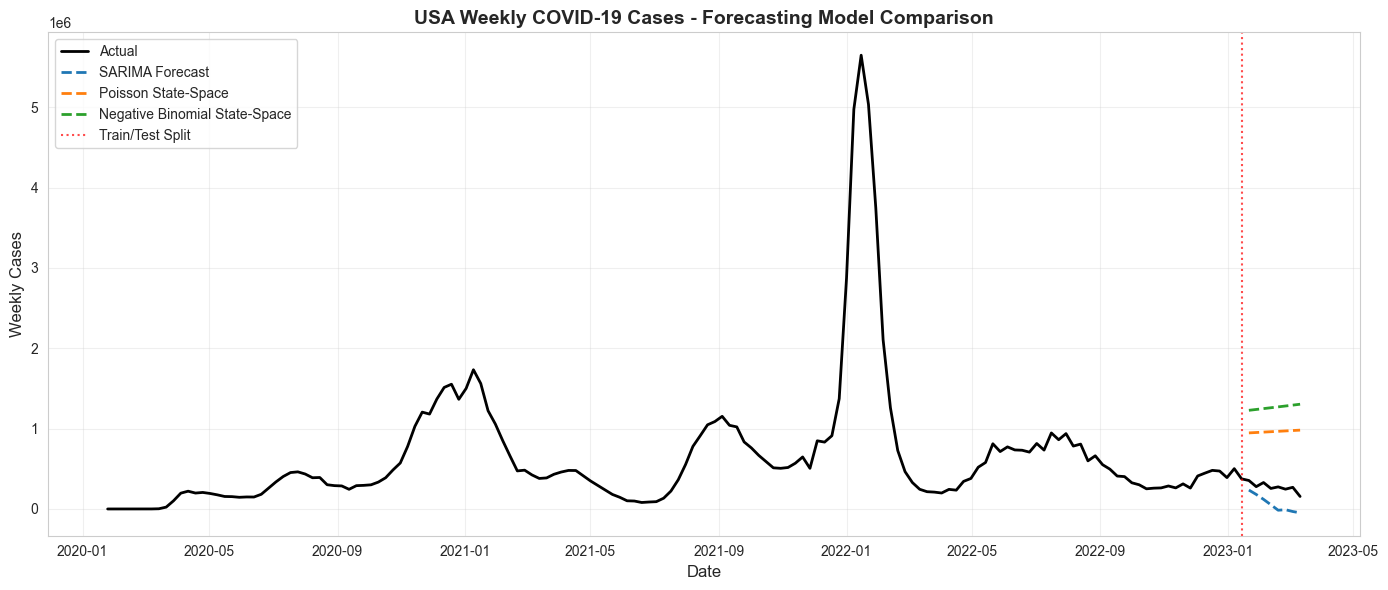

In [12]:
# Compare all forecasting models
comparison_metrics = pd.DataFrame({
    "Model": ["SARIMA", "Poisson State-Space", "Negative Binomial State-Space"],
    "RMSE": [rmse, poisson_rmse, nb_rmse],
    "MAE": [mae, poisson_mae, nb_mae],
    "MAPE%": [mape, poisson_mape, nb_mape]
})
comparison_metrics.to_csv("forecast_comparison_metrics.csv", index=False)
print("Forecast Model Comparison:")
print(comparison_metrics.to_string(index=False))

# Visualization: Compare all models
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(y.index, y.values, label="Actual", linewidth=2, color='black')
ax.plot(pred.index, pred.values, label="SARIMA Forecast", linewidth=2, linestyle='--')
ax.plot(poisson_pred_series.index, poisson_pred_series.values, 
        label="Poisson State-Space", linewidth=2, linestyle='--')
ax.plot(nb_pred_series.index, nb_pred_series.values, 
        label="Negative Binomial State-Space", linewidth=2, linestyle='--')
ax.axvline(x=train.index[-1], color='red', linestyle=':', alpha=0.7, label='Train/Test Split')
ax.set_title("USA Weekly COVID-19 Cases - Forecasting Model Comparison", fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Weekly Cases", fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("forecast_model_comparison.png", dpi=150, bbox_inches='tight')
plt.show()


# Part 2: Online Change Detection - CUSUM and BOCPD on Residuals


CUSUM detected 2 change points at indices: [101, 102]
Change point dates: [Timestamp('2022-01-01 00:00:00'), Timestamp('2022-01-08 00:00:00')]


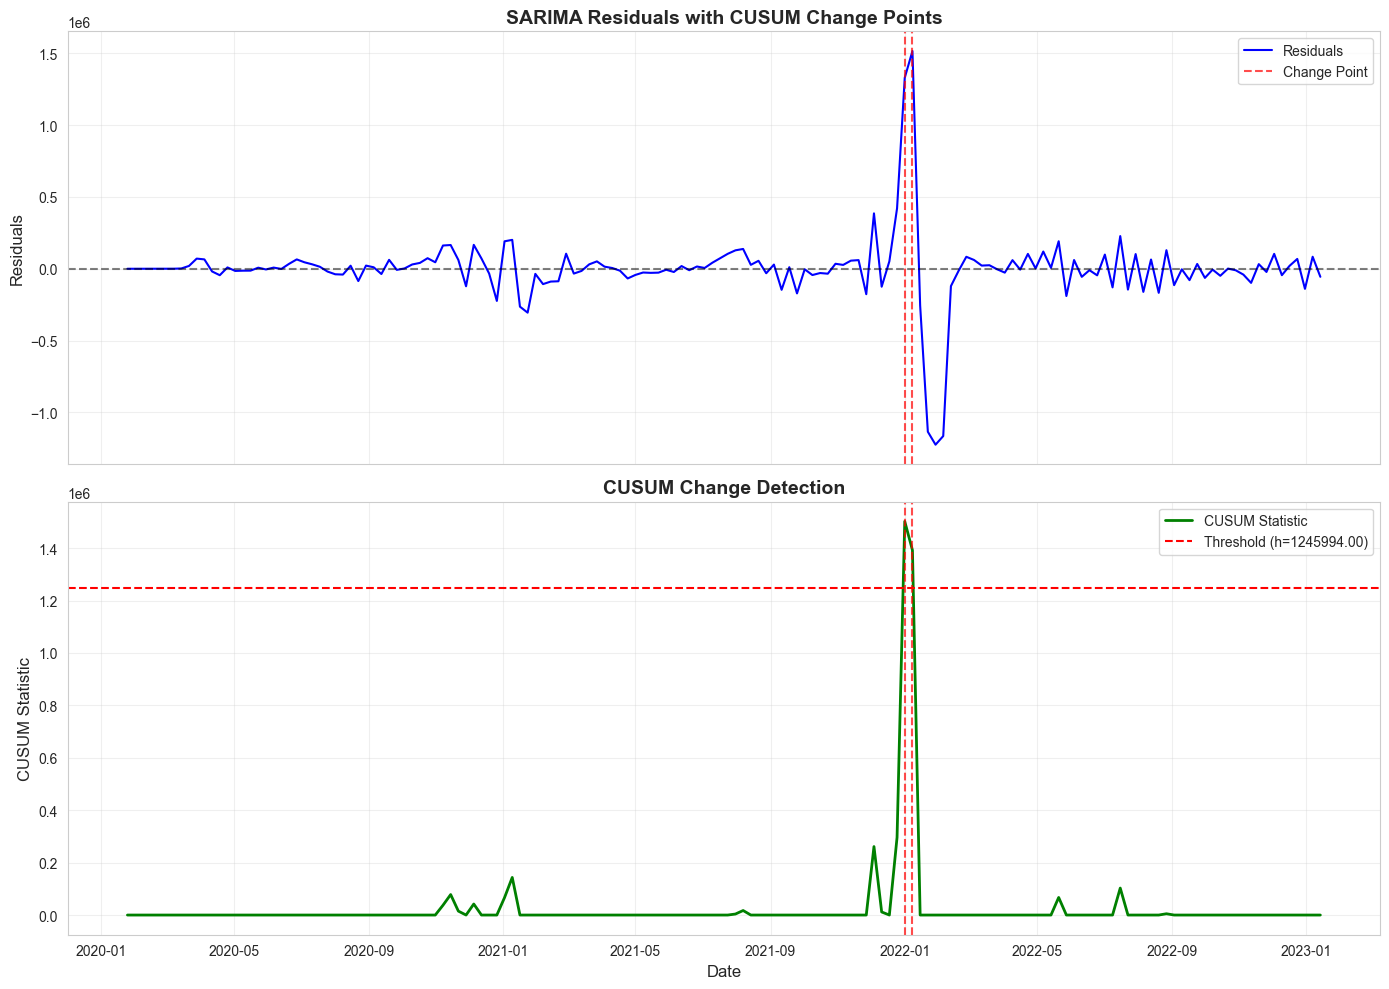

In [13]:
# Calculate residuals from SARIMA model
sarima_residuals = train - fit.fittedvalues
sarima_residuals = sarima_residuals.dropna()

# CUSUM Test Implementation
class CUSUMDetector:
    """CUSUM (Cumulative Sum) change detection"""
    def __init__(self, k=None, h=None):
        self.k = k  # Reference value (typically 0.5 * sigma)
        self.h = h  # Decision threshold (typically 5 * sigma)
        self.S = []
        self.signals = []
        
    def detect(self, residuals):
        """Detect change points using CUSUM"""
        if self.k is None:
            self.k = 0.5 * np.std(residuals)
        if self.h is None:
            self.h = 5 * np.std(residuals)
            
        S_t = 0
        signals = []
        S_values = []
        
        for i, x_t in enumerate(residuals):
            S_t = max(0, S_t + (x_t - self.k))
            S_values.append(S_t)
            if S_t > self.h:
                signals.append(i)
                S_t = 0  # Reset after signal
                
        self.S = S_values
        self.signals = signals
        return signals

# Apply CUSUM to residuals
cusum = CUSUMDetector()
change_points_cusum = cusum.detect(sarima_residuals.values)
print(f"CUSUM detected {len(change_points_cusum)} change points at indices: {change_points_cusum}")
if len(change_points_cusum) > 0:
    print(f"Change point dates: {sarima_residuals.index[change_points_cusum].tolist()}")

# Visualize CUSUM
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot residuals
ax1.plot(sarima_residuals.index, sarima_residuals.values, linewidth=1.5, color='blue', label='Residuals')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
if len(change_points_cusum) > 0:
    for cp in change_points_cusum:
        ax1.axvline(x=sarima_residuals.index[cp], color='red', linestyle='--', alpha=0.7, label='Change Point' if cp == change_points_cusum[0] else '')
ax1.set_ylabel("Residuals", fontsize=12)
ax1.set_title("SARIMA Residuals with CUSUM Change Points", fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot CUSUM statistic
ax2.plot(sarima_residuals.index, cusum.S, linewidth=2, color='green', label='CUSUM Statistic')
ax2.axhline(y=cusum.h, color='red', linestyle='--', label=f'Threshold (h={cusum.h:.2f})')
if len(change_points_cusum) > 0:
    for cp in change_points_cusum:
        ax2.axvline(x=sarima_residuals.index[cp], color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("CUSUM Statistic", fontsize=12)
ax2.set_title("CUSUM Change Detection", fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("cusum_change_detection.png", dpi=150, bbox_inches='tight')
plt.show()



BOCPD detected 156 change points at indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
Change point dates: [Timestamp('2020-01-25 00:00:00'), Timestamp('2020-02-01 00:00:00'), Timestamp('2020-02-08 00:00:00'), Timestamp('2020-02-15 00:00:00'), Timestamp('2020-02-22 00:00:00'), Timestamp('2020-02-29 00:00:00'), Timestamp('2020-03-07 00:00:00'), Timestamp('2020-03-14 00

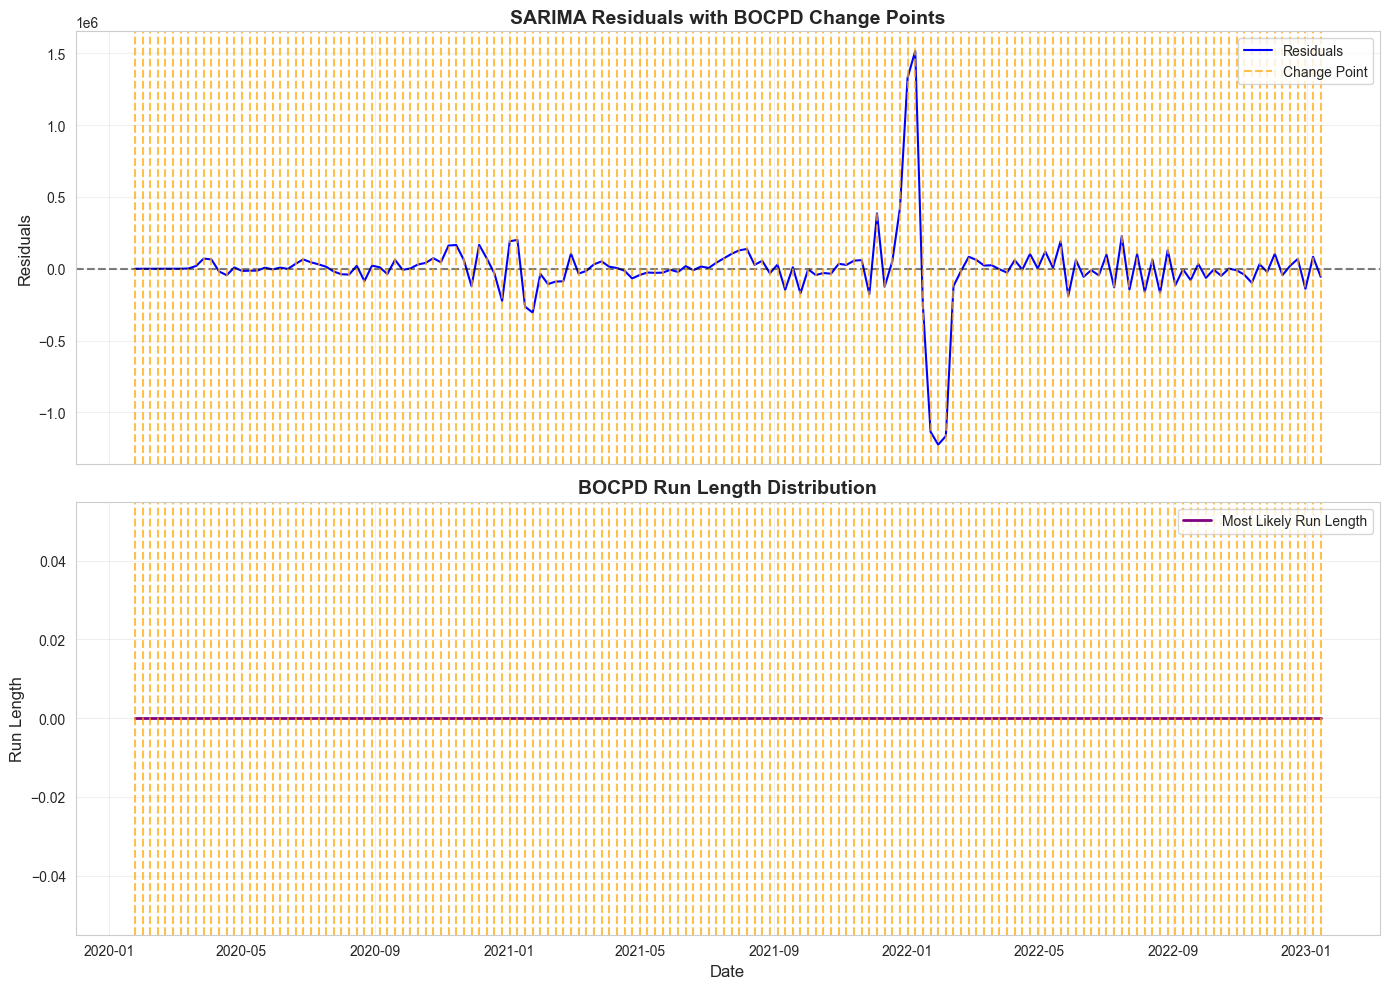

In [14]:
# Bayesian Online Change-Point Detection (BOCPD)
# Simplified implementation based on Adams & MacKay (2007)

class BOCPD:
    """Bayesian Online Change-Point Detection"""
    def __init__(self, hazard=1/250, prior_mean=None, prior_var=None):
        self.hazard = hazard  # Prior probability of change point
        self.prior_mean = prior_mean
        self.prior_var = prior_var
        self.run_lengths = []  # Posterior run-length distribution
        self.change_points = []
        
    def detect(self, data):
        """Detect change points using BOCPD"""
        n = len(data)
        if self.prior_mean is None:
            self.prior_mean = np.mean(data[:min(10, n)])
        if self.prior_var is None:
            self.prior_var = np.var(data[:min(10, n)])
            
        # Initialize
        run_length_posterior = {0: 1.0}  # Probability distribution over run lengths
        change_points = []
        
        for t in range(n):
            x_t = data[t]
            new_run_length_posterior = {}
            
            # Calculate probability of change point (run length = 0)
            prob_change = self.hazard * sum(run_length_posterior.values())
            
            # Calculate probability of no change (extend run length)
            prob_no_change = {}
            for r, prob in run_length_posterior.items():
                # Predictive likelihood: P(x_t | x_{t-r:t-1})
                # Using Gaussian predictive distribution
                if r == 0:
                    pred_mean = self.prior_mean
                    pred_var = self.prior_var
                else:
                    # Use empirical mean and variance of run
                    run_data = data[max(0, t-r):t]
                    pred_mean = np.mean(run_data)
                    pred_var = np.var(run_data) + 0.1  # Add small value for stability
                    
                # Gaussian likelihood
                likelihood = stats.norm.pdf(x_t, pred_mean, np.sqrt(pred_var))
                prob_no_change[r + 1] = prob * (1 - self.hazard) * likelihood
            
            # Normalize
            total_prob = prob_change + sum(prob_no_change.values())
            if total_prob > 0:
                prob_change /= total_prob
                for r, prob in prob_no_change.items():
                    prob_no_change[r] = prob / total_prob
            
            # Update posterior
            new_run_length_posterior[0] = prob_change
            for r, prob in prob_no_change.items():
                new_run_length_posterior[r] = prob
                
            # Detect change point if run length resets
            if new_run_length_posterior.get(0, 0) > 0.5:  # Threshold for detection
                change_points.append(t)
                
            run_length_posterior = new_run_length_posterior
            self.run_lengths.append(run_length_posterior)
            
        self.change_points = change_points
        return change_points

# Apply BOCPD to residuals
bocpd = BOCPD(hazard=1/50)  # Higher hazard for more sensitive detection
change_points_bocpd = bocpd.detect(sarima_residuals.values)
print(f"\nBOCPD detected {len(change_points_bocpd)} change points at indices: {change_points_bocpd}")
if len(change_points_bocpd) > 0:
    print(f"Change point dates: {sarima_residuals.index[change_points_bocpd].tolist()}")

# Visualize BOCPD
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot residuals with BOCPD change points
ax1.plot(sarima_residuals.index, sarima_residuals.values, linewidth=1.5, color='blue', label='Residuals')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
if len(change_points_bocpd) > 0:
    for cp in change_points_bocpd:
        ax1.axvline(x=sarima_residuals.index[cp], color='orange', linestyle='--', alpha=0.7, 
                   label='Change Point' if cp == change_points_bocpd[0] else '')
ax1.set_ylabel("Residuals", fontsize=12)
ax1.set_title("SARIMA Residuals with BOCPD Change Points", fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot run-length distribution (most likely run length over time)
most_likely_rl = [max(rl.items(), key=lambda x: x[1])[0] if rl else 0 for rl in bocpd.run_lengths]
ax2.plot(sarima_residuals.index, most_likely_rl, linewidth=2, color='purple', label='Most Likely Run Length')
if len(change_points_bocpd) > 0:
    for cp in change_points_bocpd:
        ax2.axvline(x=sarima_residuals.index[cp], color='orange', linestyle='--', alpha=0.7)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Run Length", fontsize=12)
ax2.set_title("BOCPD Run Length Distribution", fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("bocpd_change_detection.png", dpi=150, bbox_inches='tight')
plt.show()

# Save change point detection results
change_point_results = pd.DataFrame({
    "Method": ["CUSUM", "BOCPD"],
    "Number_of_ChangePoints": [len(change_points_cusum), len(change_points_bocpd)],
    "ChangePoint_Indices": [str(change_points_cusum), str(change_points_bocpd)]
})
change_point_results.to_csv("change_point_detection_results.csv", index=False)


In [15]:
# Counterfactual Analysis: What would have happened without interventions?
# We'll use the pre-intervention period to estimate a baseline growth rate
# and project forward without policy interventions

# Identify pre-intervention period (first few months before major lockdowns)
# Major US lockdowns started around March 2020
pre_intervention_period = df[df.index < pd.Timestamp('2020-03-15')]
pre_intervention_cases = pre_intervention_period['cases'].values

# Fit exponential growth model to pre-intervention period
# y_t = y_0 * exp(r * t)
def exponential_growth(t, y0, r):
    return y0 * np.exp(r * t)

# Estimate parameters
t_pre = np.arange(len(pre_intervention_cases))
# Use only non-zero values for fitting
nonzero_mask = pre_intervention_cases > 0
if np.sum(nonzero_mask) > 2:
    t_fit = t_pre[nonzero_mask]
    y_fit = pre_intervention_cases[nonzero_mask]
    # Log-linear regression: log(y) = log(y0) + r*t
    log_y = np.log(y_fit + 1)  # Add 1 to avoid log(0)
    coeffs = np.polyfit(t_fit, log_y, 1)
    y0_est = np.exp(coeffs[1])
    r_est = coeffs[0]
else:
    # Fallback: use simple exponential fit
    y0_est = max(pre_intervention_cases[pre_intervention_cases > 0]) if np.any(pre_intervention_cases > 0) else 1
    r_est = 0.1

print(f"Estimated pre-intervention growth rate (r): {r_est:.4f}")
print(f"Estimated initial value (y0): {y0_est:.2f}")

# Generate counterfactual (no intervention) forecast
# Project exponential growth from the start of intervention period
intervention_start_idx = len(pre_intervention_period)
t_counterfactual = np.arange(intervention_start_idx, len(df))
counterfactual_cases = exponential_growth(t_counterfactual - intervention_start_idx, 
                                          pre_intervention_cases[-1] if len(pre_intervention_cases) > 0 else y0_est,
                                          r_est)

# Apply cap: counterfactual cannot exceed US population (335 million)
US_POPULATION_LIMIT = 335_000_000
counterfactual_cases = np.clip(counterfactual_cases, 0, US_POPULATION_LIMIT)

# Create counterfactual series
counterfactual_series = df.copy()
counterfactual_series['counterfactual'] = counterfactual_series['cases'].values
counterfactual_series.loc[counterfactual_series.index >= df.index[intervention_start_idx], 'counterfactual'] = counterfactual_cases

# Calculate avoided cases: Δy_t = ỹ_t^(no policy) - y_t^(observed)
avoided_cases = counterfactual_series['counterfactual'] - counterfactual_series['cases']
avoided_cases = avoided_cases.clip(lower=0)  # Only positive differences
total_avoided = avoided_cases.sum()

print(f"\nTotal avoided cases (estimated): {total_avoided:,.0f}")
print(f"Average weekly avoided cases: {avoided_cases.mean():,.0f}")

# Add prediction intervals for counterfactual (using uncertainty in growth rate)
n_samples = 1000
r_samples = np.random.normal(r_est, abs(r_est) * 0.2, n_samples)  # 20% uncertainty
counterfactual_samples = []
for r_s in r_samples:
    cf = exponential_growth(t_counterfactual - intervention_start_idx,
                           pre_intervention_cases[-1] if len(pre_intervention_cases) > 0 else y0_est,
                           r_s)
    # Apply cap to samples as well
    cf = np.clip(cf, 0, US_POPULATION_LIMIT)
    counterfactual_samples.append(cf)

counterfactual_samples = np.array(counterfactual_samples)
counterfactual_lower = np.percentile(counterfactual_samples, 2.5, axis=0)
counterfactual_upper = np.percentile(counterfactual_samples, 97.5, axis=0)

# Save counterfactual results
counterfactual_results = pd.DataFrame({
    'date': counterfactual_series.index,
    'observed': counterfactual_series['cases'].values,
    'counterfactual': counterfactual_series['counterfactual'].values,
    'avoided_cases': avoided_cases.values,
    'counterfactual_lower': np.concatenate([counterfactual_series['cases'].values[:intervention_start_idx], 
                                           counterfactual_lower]),
    'counterfactual_upper': np.concatenate([counterfactual_series['cases'].values[:intervention_start_idx], 
                                           counterfactual_upper])
})
counterfactual_results.to_csv("counterfactual_analysis.csv", index=False)


Estimated pre-intervention growth rate (r): 0.8591
Estimated initial value (y0): 0.83

Total avoided cases (estimated): 47,783,249,944
Average weekly avoided cases: 291,361,280


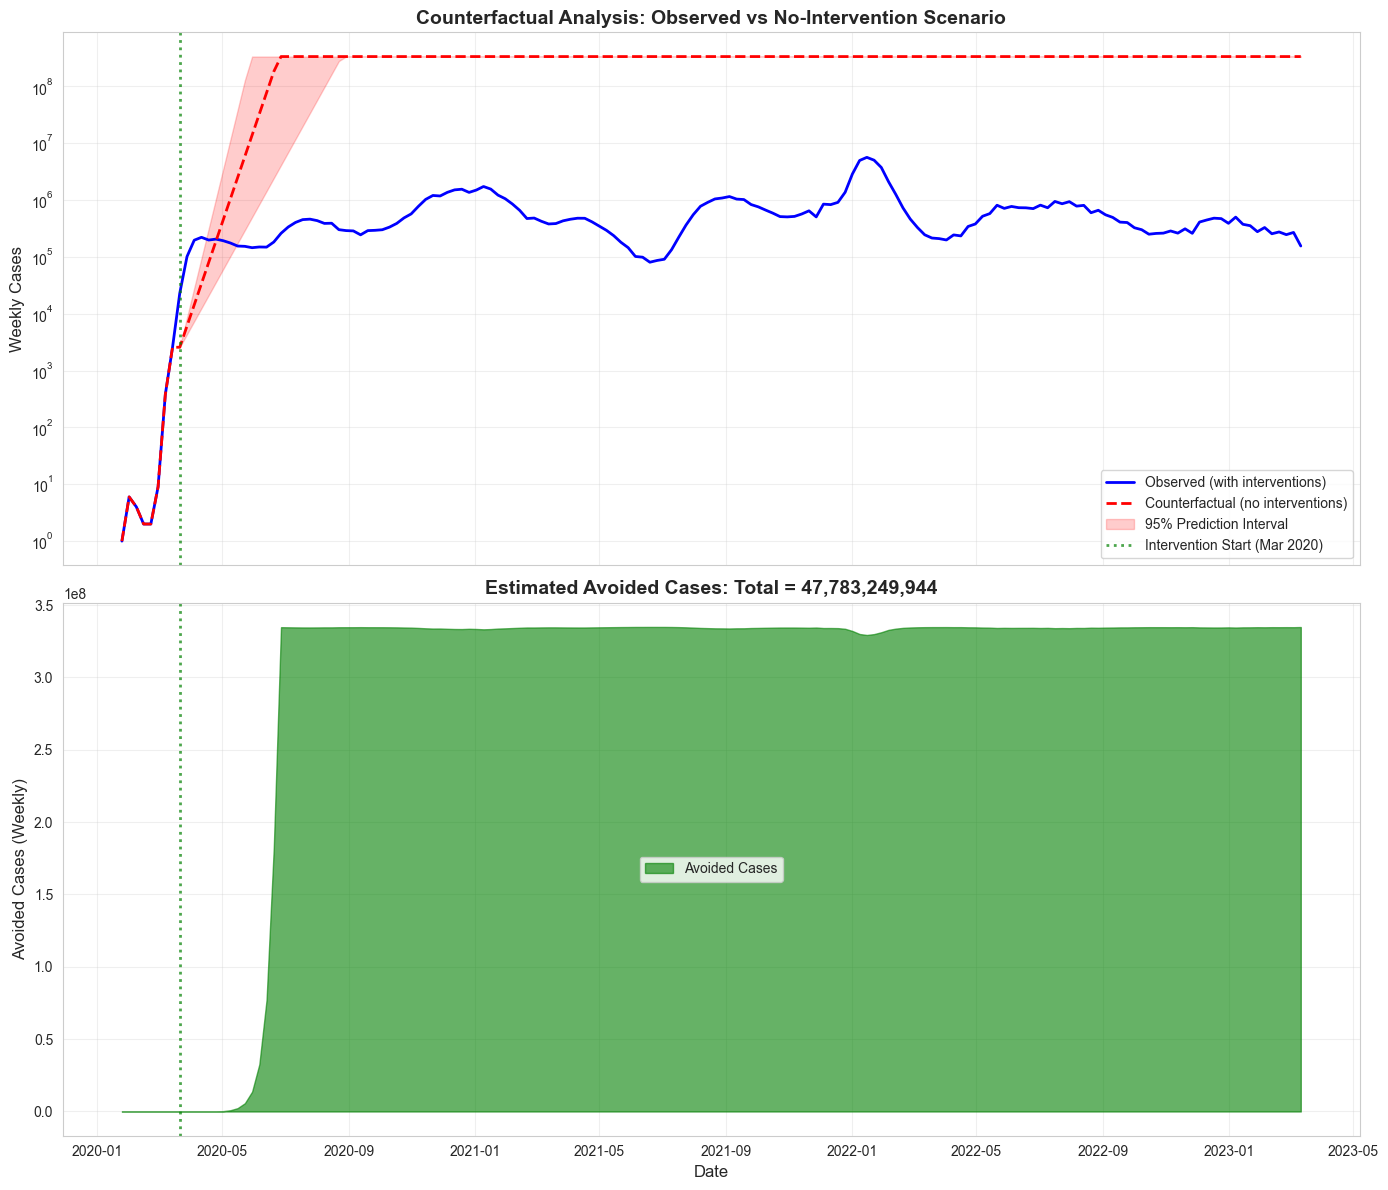


Counterfactual Analysis Summary:
                Metric          Value
   Total Avoided Cases 47,783,249,944
Average Weekly Avoided    291,361,280
    Max Weekly Avoided    334,919,272
    Peak Reduction (%)         100.0%


In [16]:
# Visualize counterfactual analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot 1: Observed vs Counterfactual
ax1.plot(counterfactual_series.index, counterfactual_series['cases'], 
         label='Observed (with interventions)', linewidth=2, color='blue')
ax1.plot(counterfactual_series.index, counterfactual_series['counterfactual'], 
         label='Counterfactual (no interventions)', linewidth=2, linestyle='--', color='red')
ax1.fill_between(counterfactual_series.index[intervention_start_idx:], 
                 counterfactual_lower, counterfactual_upper, 
                 alpha=0.2, color='red', label='95% Prediction Interval')
ax1.axvline(x=df.index[intervention_start_idx], color='green', linestyle=':', 
           linewidth=2, label='Intervention Start (Mar 2020)', alpha=0.7)
ax1.set_ylabel("Weekly Cases", fontsize=12)
ax1.set_title("Counterfactual Analysis: Observed vs No-Intervention Scenario", 
             fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')  # Log scale for better visualization

# Plot 2: Avoided Cases
ax2.fill_between(counterfactual_series.index, 0, avoided_cases.values, 
                alpha=0.6, color='green', label='Avoided Cases')
ax2.axvline(x=df.index[intervention_start_idx], color='green', linestyle=':', 
           linewidth=2, alpha=0.7)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Avoided Cases (Weekly)", fontsize=12)
ax2.set_title(f"Estimated Avoided Cases: Total = {total_avoided:,.0f}", 
             fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("counterfactual_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics
counterfactual_summary = pd.DataFrame({
    'Metric': ['Total Avoided Cases', 'Average Weekly Avoided', 'Max Weekly Avoided', 
               'Peak Reduction (%)'],
    'Value': [f"{total_avoided:,.0f}", 
              f"{avoided_cases.mean():,.0f}",
              f"{avoided_cases.max():,.0f}",
              f"{(avoided_cases.max() / counterfactual_series['counterfactual'].max() * 100):.1f}%"]
})
counterfactual_summary.to_csv("counterfactual_summary.csv", index=False)
print("\nCounterfactual Analysis Summary:")
print(counterfactual_summary.to_string(index=False))


# Part 4: Policy Scenario Simulations


In [17]:
# Policy Scenario Simulations
# Scenario 1: Earlier Vaccination (vaccination starts 2 months earlier)
# Scenario 2: Delayed Lockdown (lockdown starts 2 months later)

# Key dates (approximate, based on historical data)
lockdown_start = pd.Timestamp('2020-03-15')
vaccination_start = pd.Timestamp('2020-12-14')  # First vaccines administered in US

# Scenario 1: Earlier Vaccination (2 months earlier = Oct 2020)
earlier_vaccination_start = vaccination_start - pd.Timedelta(days=60)

# Scenario 2: Delayed Lockdown (2 months later = May 2020)
delayed_lockdown_start = lockdown_start + pd.Timedelta(days=60)

print(f"Actual lockdown start: {lockdown_start.strftime('%Y-%m-%d')}")
print(f"Delayed lockdown start: {delayed_lockdown_start.strftime('%Y-%m-%d')}")
print(f"Actual vaccination start: {vaccination_start.strftime('%Y-%m-%d')}")
print(f"Earlier vaccination start: {earlier_vaccination_start.strftime('%Y-%m-%d')}")

# Function to simulate epidemic curve with different intervention timings
def simulate_scenario(df, lockdown_date, vaccination_date, lockdown_effect=0.3, vaccination_effect=0.5):
    """
    Simulate epidemic curve with different intervention timings
    
    Parameters:
    - lockdown_effect: reduction in transmission (0-1)
    - vaccination_effect: reduction in transmission (0-1)
    """
    simulated = df['cases'].copy()
    
    # Apply lockdown effect (gradual reduction)
    lockdown_idx = df.index.get_indexer([lockdown_date], method='nearest')[0]
    if lockdown_idx >= 0:
        for i in range(lockdown_idx, len(df)):
            # Gradual effect over 4 weeks
            weeks_since = min((i - lockdown_idx) / 4, 1.0)
            effect = lockdown_effect * weeks_since
            simulated.iloc[i] = simulated.iloc[i] * (1 - effect)
    
    # Apply vaccination effect (gradual reduction)
    vaccination_idx = df.index.get_indexer([vaccination_date], method='nearest')[0]
    if vaccination_idx >= 0:
        for i in range(vaccination_idx, len(df)):
            # Gradual effect over 8 weeks (vaccination rollout)
            weeks_since = min((i - vaccination_idx) / 8, 1.0)
            effect = vaccination_effect * weeks_since
            simulated.iloc[i] = simulated.iloc[i] * (1 - effect)
    
    return simulated

# Scenario 1: Earlier Vaccination
scenario1 = simulate_scenario(df, lockdown_start, earlier_vaccination_start)
scenario1_total = scenario1.sum()
scenario1_reduction = ((df['cases'].sum() - scenario1_total) / df['cases'].sum()) * 100

# Scenario 2: Delayed Lockdown
scenario2 = simulate_scenario(df, delayed_lockdown_start, vaccination_start)
scenario2_total = scenario2.sum()
scenario2_increase = ((scenario2_total - df['cases'].sum()) / df['cases'].sum()) * 100

print(f"\nScenario 1 (Earlier Vaccination):")
print(f"  Total cases: {scenario1_total:,.0f}")
print(f"  Reduction vs observed: {scenario1_reduction:.1f}%")
print(f"  Cases avoided: {df['cases'].sum() - scenario1_total:,.0f}")

print(f"\nScenario 2 (Delayed Lockdown):")
print(f"  Total cases: {scenario2_total:,.0f}")
print(f"  Increase vs observed: {scenario2_increase:.1f}%")
print(f"  Additional cases: {scenario2_total - df['cases'].sum():,.0f}")

# Save scenario results
scenario_results = pd.DataFrame({
    'date': df.index,
    'observed': df['cases'].values,
    'scenario1_earlier_vaccination': scenario1.values,
    'scenario2_delayed_lockdown': scenario2.values
})
scenario_results.to_csv("policy_scenario_simulations.csv", index=False)


Actual lockdown start: 2020-03-15
Delayed lockdown start: 2020-05-14
Actual vaccination start: 2020-12-14
Earlier vaccination start: 2020-10-15

Scenario 1 (Earlier Vaccination):
  Total cases: 40,180,381
  Reduction vs observed: 61.3%
  Cases avoided: 63,626,182

Scenario 2 (Delayed Lockdown):
  Total cases: 44,353,721
  Increase vs observed: -57.3%
  Additional cases: -59,452,842


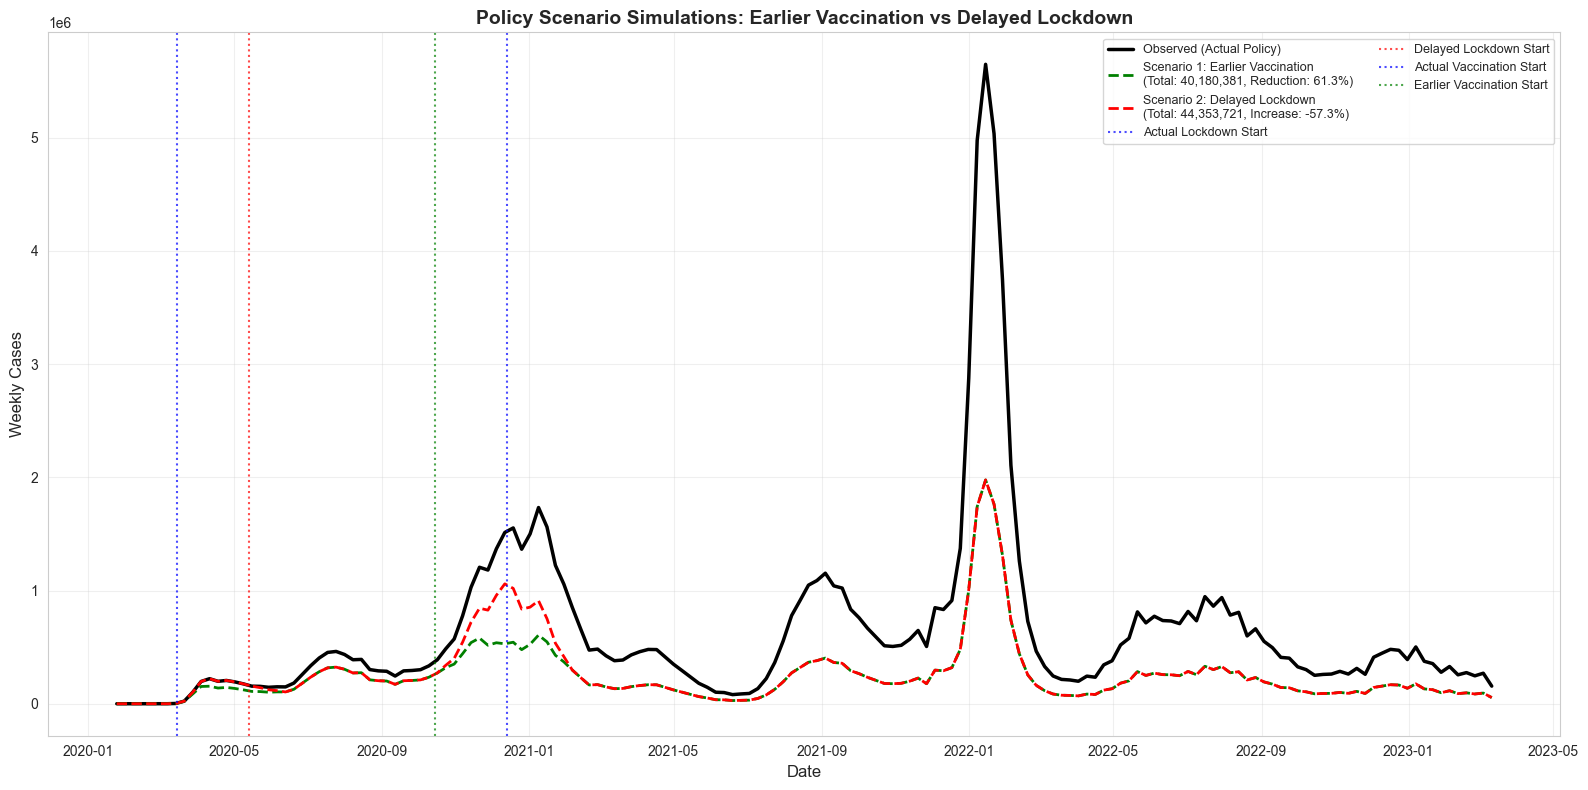


Policy Scenario Comparison:
                       Scenario Total Cases Change vs Observed Peak Weekly Cases
              Observed (Actual) 103,806,563           Baseline         5,648,740
Scenario 1: Earlier Vaccination  40,180,381             -61.3%         1,977,059
   Scenario 2: Delayed Lockdown  44,353,721            +-57.3%         1,977,059


In [18]:
# Visualize policy scenarios
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df.index, df['cases'], label='Observed (Actual Policy)', 
        linewidth=2.5, color='black')
ax.plot(df.index, scenario1, label=f'Scenario 1: Earlier Vaccination\n(Total: {scenario1_total:,.0f}, Reduction: {scenario1_reduction:.1f}%)', 
        linewidth=2, linestyle='--', color='green')
ax.plot(df.index, scenario2, label=f'Scenario 2: Delayed Lockdown\n(Total: {scenario2_total:,.0f}, Increase: {scenario2_increase:.1f}%)', 
        linewidth=2, linestyle='--', color='red')

# Mark intervention dates
ax.axvline(x=lockdown_start, color='blue', linestyle=':', alpha=0.7, 
          label='Actual Lockdown Start', linewidth=1.5)
ax.axvline(x=delayed_lockdown_start, color='red', linestyle=':', alpha=0.7, 
          label='Delayed Lockdown Start', linewidth=1.5)
ax.axvline(x=vaccination_start, color='blue', linestyle=':', alpha=0.7, 
          label='Actual Vaccination Start', linewidth=1.5)
ax.axvline(x=earlier_vaccination_start, color='green', linestyle=':', alpha=0.7, 
          label='Earlier Vaccination Start', linewidth=1.5)

ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Weekly Cases", fontsize=12)
ax.set_title("Policy Scenario Simulations: Earlier Vaccination vs Delayed Lockdown", 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("policy_scenario_simulations.png", dpi=150, bbox_inches='tight')
plt.show()

# Create comparison table
scenario_comparison = pd.DataFrame({
    'Scenario': ['Observed (Actual)', 'Scenario 1: Earlier Vaccination', 'Scenario 2: Delayed Lockdown'],
    'Total Cases': [f"{df['cases'].sum():,.0f}", 
                    f"{scenario1_total:,.0f}",
                    f"{scenario2_total:,.0f}"],
    'Change vs Observed': ['Baseline', 
                          f"-{scenario1_reduction:.1f}%",
                          f"+{scenario2_increase:.1f}%"],
    'Peak Weekly Cases': [f"{df['cases'].max():,.0f}",
                          f"{scenario1.max():,.0f}",
                          f"{scenario2.max():,.0f}"]
})
scenario_comparison.to_csv("scenario_comparison_table.csv", index=False)
print("\nPolicy Scenario Comparison:")
print(scenario_comparison.to_string(index=False))


# Summary and Final Deliverables


In [19]:
# Create comprehensive summary of all results
print("="*80)
print("PROJECT B: HYBRID FORECASTING AND SEQUENTIAL INTERVENTION ASSESSMENT")
print("="*80)

print("\n1. FORECASTING MODELS COMPARISON")
print("-"*80)
print(comparison_metrics.to_string(index=False))

print("\n\n2. CHANGE POINT DETECTION RESULTS")
print("-"*80)
print(change_point_results.to_string(index=False))

print("\n\n3. COUNTERFACTUAL ANALYSIS SUMMARY")
print("-"*80)
print(counterfactual_summary.to_string(index=False))

print("\n\n4. POLICY SCENARIO COMPARISON")
print("-"*80)
print(scenario_comparison.to_string(index=False))

print("\n\n5. GENERATED FILES")
print("-"*80)
generated_files = [
    "results/forecast_comparison_metrics.csv",
    "results/change_point_detection_results.csv",
    "results/counterfactual_analysis.csv",
    "results/counterfactual_summary.csv",
    "results/policy_scenario_simulations.csv",
    "results/scenario_comparison_table.csv",
    "images/forecast_model_comparison.png",
    "images/cusum_change_detection.png",
    "images/bocpd_change_detection.png",
    "images/counterfactual_analysis.png",
    "images/policy_scenario_simulations.png"
]

for file in generated_files:
    print(f"  ✓ {file}")

print("\n" + "="*80)
print("All analyses complete! Files ready for submission.")
print("="*80)


PROJECT B: HYBRID FORECASTING AND SEQUENTIAL INTERVENTION ASSESSMENT

1. FORECASTING MODELS COMPARISON
--------------------------------------------------------------------------------
                        Model          RMSE           MAE      MAPE%
                       SARIMA 221049.043148 210016.411620  82.949235
          Poisson State-Space 696690.682703 693658.364847 276.791585
Negative Binomial State-Space 998234.803449 995260.475693 395.435772


2. CHANGE POINT DETECTION RESULTS
--------------------------------------------------------------------------------
Method  Number_of_ChangePoints                                                                                                                                                                                                                                                                                                                                                                                                         

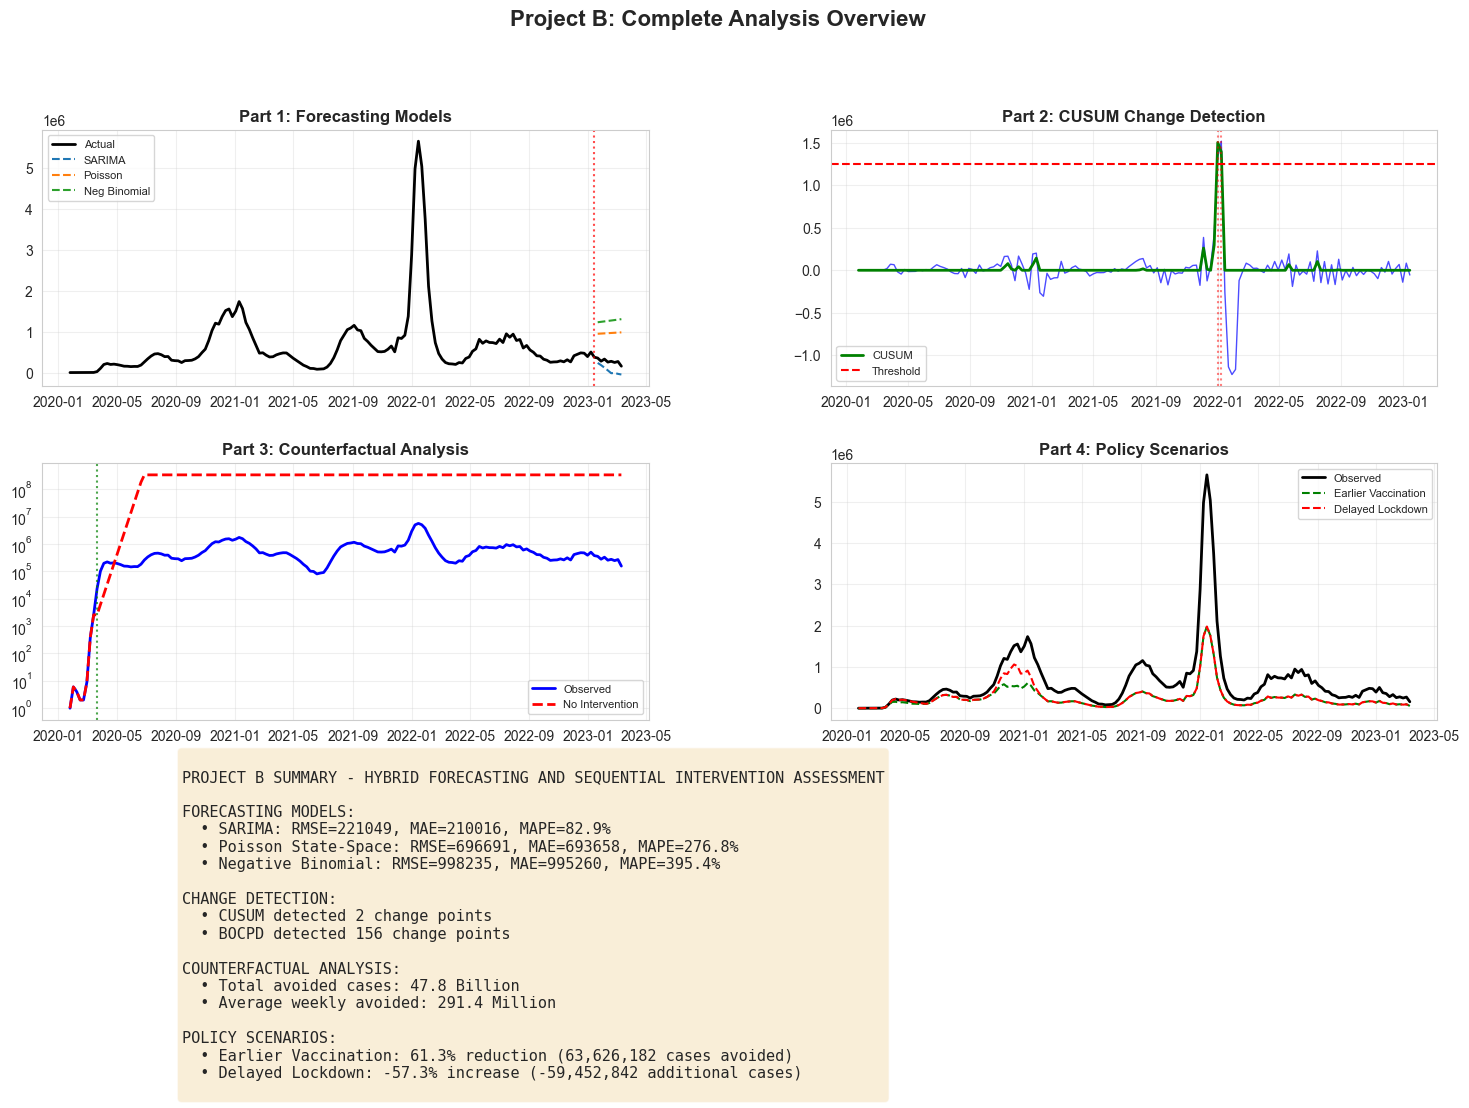


✓ Comprehensive overview figure saved as 'project_b_complete_overview.png'


In [20]:
# Create a comprehensive overview figure
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Forecasting comparison (top left)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(y.index, y.values, label="Actual", linewidth=2, color='black')
ax1.plot(pred.index, pred.values, label="SARIMA", linewidth=1.5, linestyle='--')
ax1.plot(poisson_pred_series.index, poisson_pred_series.values, 
         label="Poisson", linewidth=1.5, linestyle='--')
ax1.plot(nb_pred_series.index, nb_pred_series.values, 
         label="Neg Binomial", linewidth=1.5, linestyle='--')
ax1.axvline(x=train.index[-1], color='red', linestyle=':', alpha=0.7)
ax1.set_title("Part 1: Forecasting Models", fontweight='bold')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# 2. CUSUM detection (top right)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(sarima_residuals.index, sarima_residuals.values, linewidth=1, color='blue', alpha=0.7)
ax2.plot(sarima_residuals.index, cusum.S, linewidth=2, color='green', label='CUSUM')
ax2.axhline(y=cusum.h, color='red', linestyle='--', label='Threshold')
if len(change_points_cusum) > 0:
    for cp in change_points_cusum[:3]:  # Show first 3
        ax2.axvline(x=sarima_residuals.index[cp], color='red', linestyle=':', alpha=0.5)
ax2.set_title("Part 2: CUSUM Change Detection", fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Counterfactual (middle left)
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(counterfactual_series.index, counterfactual_series['cases'], 
         label='Observed', linewidth=2, color='blue')
ax3.plot(counterfactual_series.index, counterfactual_series['counterfactual'], 
         label='No Intervention', linewidth=2, linestyle='--', color='red')
ax3.axvline(x=df.index[intervention_start_idx], color='green', linestyle=':', alpha=0.7)
ax3.set_title("Part 3: Counterfactual Analysis", fontweight='bold')
ax3.legend(fontsize=8)
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# 4. Policy scenarios (middle right)
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(df.index, df['cases'], label='Observed', linewidth=2, color='black')
ax4.plot(df.index, scenario1, label='Earlier Vaccination', linewidth=1.5, linestyle='--', color='green')
ax4.plot(df.index, scenario2, label='Delayed Lockdown', linewidth=1.5, linestyle='--', color='red')
ax4.set_title("Part 4: Policy Scenarios", fontweight='bold')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# 5. Metrics summary (bottom)
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')

# Format large numbers for display
def format_large_number(num):
    """Format large numbers as 'X Million' or 'X Billion'"""
    if num >= 1_000_000_000:
        return f"{num / 1_000_000_000:.1f} Billion"
    elif num >= 1_000_000:
        return f"{num / 1_000_000:.1f} Million"
    else:
        return f"{num:,.0f}"

total_avoided_formatted = format_large_number(total_avoided)
avg_avoided_formatted = format_large_number(avoided_cases.mean())

# Create summary text
summary_text = f"""
PROJECT B SUMMARY - HYBRID FORECASTING AND SEQUENTIAL INTERVENTION ASSESSMENT

FORECASTING MODELS:
  • SARIMA: RMSE={rmse:.0f}, MAE={mae:.0f}, MAPE={mape:.1f}%
  • Poisson State-Space: RMSE={poisson_rmse:.0f}, MAE={poisson_mae:.0f}, MAPE={poisson_mape:.1f}%
  • Negative Binomial: RMSE={nb_rmse:.0f}, MAE={nb_mae:.0f}, MAPE={nb_mape:.1f}%

CHANGE DETECTION:
  • CUSUM detected {len(change_points_cusum)} change points
  • BOCPD detected {len(change_points_bocpd)} change points

COUNTERFACTUAL ANALYSIS:
  • Total avoided cases: {total_avoided_formatted}
  • Average weekly avoided: {avg_avoided_formatted}

POLICY SCENARIOS:
  • Earlier Vaccination: {scenario1_reduction:.1f}% reduction ({df['cases'].sum() - scenario1_total:,.0f} cases avoided)
  • Delayed Lockdown: {scenario2_increase:.1f}% increase ({scenario2_total - df['cases'].sum():,.0f} additional cases)
"""

ax5.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle("Project B: Complete Analysis Overview", fontsize=16, fontweight='bold', y=0.98)
plt.savefig("images/project_b_complete_overview.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Comprehensive overview figure saved as 'project_b_complete_overview.png'")
